## Multi-generation climate model inter-comparison

This notebook uses [`intake-esm`](https://intake-esm.readthedocs.io/en/latest/) to ingest and organize climate model output from various model generations from 1990-2019 and [`xskillscore`](https://github.com/raybellwaves/xskillscore) to calculate model skill with respect to NCEP Reanalysis 

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xskillscore as xs
import xesmf as xe
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import intake
# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util 

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

/srv/conda/envs/notebook/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


## Data catalogs

In [2]:
col_dict = {}
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
col_dict["CMIP6"] = col
col

pangeo-cmip6-ESM Collection with 28691 entries:
	> 10 activity_id(s)

	> 23 institution_id(s)

	> 48 source_id(s)

	> 29 experiment_id(s)

	> 86 member_id(s)

	> 23 table_id(s)

	> 190 variable_id(s)

	> 7 grid_label(s)

	> 28691 zstore(s)

	> 59 dcpp_init_year(s)

In [3]:
col = intake.open_esm_datastore("../catalogs/adhoc-ipcc-ar.json")
col_dict["pre-CMIP6"] = col
col

adhoc-ipcc-ar-ESM Collection with 44 entries:
	> 3 mip_id(s)

	> 1 activity_id(s)

	> 12 institution_id(s)

	> 12 source_id(s)

	> 1 experiment_id(s)

	> 1 member_id(s)

	> 1 table_id(s)

	> 3 variable_id(s)

	> 44 zstore(s)

In [4]:
mip_catalog_dict = {"FAR": "pre-CMIP6",
                    "SAR": "pre-CMIP6",
                    "TAR": "pre-CMIP6",
                    "CMIP6": "CMIP6"}

mip_ids = mip_catalog_dict.keys()
mip_ids

dict_keys(['FAR', 'SAR', 'TAR', 'CMIP6'])

## The task at hand

- Loop through the `source_id` for `experiment_id == 'historical'`
- For each model:
    - select only a single ensemble member (at least for now)
    - Take a slice `time=slice('1981', '2010')` and compute time average over that slice (date range consistent with the long-term climatology of the NCEP reanalysis, to which we are comparing
    - Regrid the `tas` data to a common grid
    - drop redundant variables (like "height: 2m")
    - concatenate to ensemble dataset along `ensemble` dimension

### Defining a regridding function

In [5]:
# Define the common target grid axes
dlon, dlat = 1., 1.
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90.+dlat/2., 90., dlat)),
                     'lon': (['lon'], np.arange(0.+dlon/2., 360., dlon)),})

# Regridding function
def regrid_to_common(ds, ds_out):
    """
    Regrid from rectilinear grid to common grid
    """
    regridder = xe.Regridder(ds, ds_out, 'bilinear',periodic=True, reuse_weights=True)
    return regridder(ds)

In [6]:
Rearth = 6.378E6   # radius of Earth in meters
# a DataArray that gives grid cell areas on the lat/lon grid (in units of m^2)
area = (np.deg2rad(dlat)*Rearth) * (np.deg2rad(dlon)*Rearth*np.cos(np.deg2rad(ds_out.lat))) * xr.ones_like(ds_out.lon)

### Loading data

`intake-esm` enables loading data directly into an [xarray.Dataset](http://xarray.pydata.org/en/stable/api.html#dataset).

Note that data on the cloud are in 
[zarr](https://zarr.readthedocs.io/en/stable/) format and data on 
[glade](https://www2.cisl.ucar.edu/resources/storage-and-file-systems/glade-file-spaces) are stored as 
[netCDF](https://www.unidata.ucar.edu/software/netcdf/) files. This is opaque to the user.

`intake-esm` has rules for aggegating datasets; these rules are defined in the collection-specification file.

In [7]:
#varnames = ['tas','psl','pr','uas','vas']
varnames = ['tas', 'pr']
time_slice = slice('1981', '2010') # date range consistent with NCEP reanalysis long-term-mean

In [8]:
# For converting units for precip output
cm_to_m = 1.e-2
rho_water = 1.e3
day_in_s = (24.*60.*60.)

In [9]:
ds_dict = {}

for mip_id in tqdm(mip_ids):
    ds_dict[mip_id] = {}
    for varname in varnames:
        
        col = col_dict[mip_catalog_dict[mip_id]]
        cat = col.search(experiment_id='historical', 
                         table_id='Amon', 
                         variable_id=varname,
                         member_id='r1i1p1f1'  # choose first ensemble member only (for now)
                        )

        dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False})

        ds_dict[mip_id][varname] = {}
        for key, ds in dset_dict.items():
            if (mip_catalog_dict[mip_id] == 'pre-CMIP6') and (mip_id != key.split(".")[-1]): continue
            
            # rename spatial dimensions if necessary
            if ('longitude' in ds.dims) and ('latitude' in ds.dims):
                ds = ds.rename({'longitude':'lon', 'latitude': 'lat'})
            ds = xr.decode_cf(ds) # Need this temporarily because setting 'decode_times': True appears broken
            ds = ds.squeeze() # get rid of member_id (for now)
            
            # take long-term mean
            timeave = ds.sel(time=time_slice).mean(dim='time')
            
            # modify pre-CMIP6 chunks
            if mip_catalog_dict[mip_id] == 'pre-CMIP6':
                timeave = timeave.chunk({'lat':timeave['lat'].size, 'lon':timeave['lon'].size})
            
            # regrid to common grid
            ds_new = regrid_to_common(timeave[varname], ds_out)

            # Add metadata and apply various corrections
            if mip_catalog_dict[mip_id] == 'CMIP6':
                # Correct MCM-UA precipitation due to broken units (Ron Stouffer, personal communication)
                if ('MCM-UA' in ds.attrs['parent_source_id']) and (varname == 'pr'):
                    # convert from cm/day to kg/m^2/s
                    ds_new *= (cm_to_m * rho_water / day_in_s)
                    
                # TEMPORARY FIX: Correct BCC-ESM1 and CanESM5 which inexplicably have latitude flipped
                if ("BCC-ESM1" in key) or ("CanESM5" in key):
                    ds_new['lat'].values = ds_new['lat'].values[::-1]

                ds_new.attrs['name'] = ds.attrs['source_id']
                
            else:
                # Maybe chance this at pre-processing stage?
                ds_new.attrs['name'] = ds.attrs['institution']
            
            # drop redundant variables (like "height: 2m")
            for coord in ds_new.coords:
                if coord not in ['lat','lon']:
                    ds_new = ds_new.drop(coord)

            # Add ensemble as new dimension
            ds_new = ds_new.expand_dims({'ensemble': np.array([ds_new.attrs['name']])}, 0)

            # Add var as new dimension
            ds_new = ds_new.expand_dims({'var': np.array([varname])}, 0)

            # We should keep the metadata!!!
            ds_new.attrs['mip_id'] = mip_id
            
            ds_dict[mip_id][varname][key] = ds_new  # add this to the dictionary

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.mip_id'

--> There will be 16 group(s)
Reuse existing file: bilinear_40x48_180x360_peri.nc
Reuse existing file: bilinear_24x36_180x360_peri.nc
Reuse existing file: bilinear_72x96_180x360_peri.nc
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.mip_id'

--> There will be 16 group(s)
Reuse existing file: bilinear_40x48_180x360_peri.nc
Reuse existing file: bilinear_24x36_180x360_peri.nc
Reuse existing file: bilinear_72x96_180x360_peri.nc
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.mip_id'

--> There will be 16 group(s)
Reuse existing file: bilinear_48x96_180x360_peri.nc
Reuse existing file: bilinear_32x64_180x360_peri.nc
Reuse existing file: bilinear_56x64_180x3

In [10]:
ens_dict = {}

for mip_id in mip_ids:
    ens = (
        xr.concat([
            xr.concat([ds for name, ds in ds_dict[mip_id][varname].items()], dim='ensemble')
            for varname in varnames
        ],dim='var')
    )

    ens = xr.concat(
        [ens, ens.mean(dim='ensemble', skipna=True).expand_dims({'ensemble': np.array(['ens-mean'])}, 0)],
        dim='ensemble'
    )
    
    ens.name = mip_id
    ens_dict[mip_id] = ens
    
ens_dict

{'FAR': <xarray.DataArray 'FAR' (var: 2, ensemble: 4, lat: 180, lon: 360)>
 dask.array<concatenate, shape=(2, 4, 180, 360), dtype=float64, chunksize=(1, 1, 180, 360), chunktype=numpy.ndarray>
 Coordinates:
   * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
   * lon       (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
   * var       (var) object 'tas' 'pr'
   * ensemble  (ensemble) object 'GFDL' 'GISS' 'UKTR' 'ens-mean',
 'SAR': <xarray.DataArray 'SAR' (var: 2, ensemble: 9, lat: 180, lon: 360)>
 dask.array<concatenate, shape=(2, 9, 180, 360), dtype=float64, chunksize=(1, 1, 180, 360), chunktype=numpy.ndarray>
 Coordinates:
   * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
   * lon       (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
   * var       (var) object 'tas' 'pr'
   * ensemble  (ensemble) object 'CCCma' 'CCSR-NIES' ... 'NCAR' 'ens-mean',
 'TAR': <xarray.DataArray 'TAR' (var: 2, ensemble: 6, lat: 1

## Some 'observational' reference data to compare models against

We will use long-term mean climatology from NCEP reanalysis (because it's easy)

In [11]:
# Paths gotten from:
# https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.derived.surface.html
# https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.derived.surfaceflux.html

ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_paths_dict = {"tas": "surface/air.mon.ltm.nc",
                   "psl": "surface/slp.mon.ltm.nc",
                   "pr": "surface_gauss/prate.sfc.mon.ltm.nc",
                   "uas": "surface/uwnd.mon.ltm.nc",
                   "vas": "surface/vwnd.mon.ltm.nc"}

def convert_ncep_units_to_cf(da):
    if da.attrs['units'] == "degC":
        da += 273.15
        da.attrs['units'] = "K"
    elif da.attrs['units'] == "millibars":
        da *= 100.
        da.attrs['units'] = "Pa"
    return da

ncep_list = []
for varname, path in ncep_paths_dict.items():
    # Check that we read in same variables as models
    if varname not in varnames: continue
    
    ncep_ds = xr.open_dataset(ncep_url + path)
    ncep_var_name = path.split("/")[1].split(".")[0]
    
    # Long-term monthly climatology 1981-2010
    ncep_var_native = ncep_ds[ncep_var_name]
    
    # Convert NCEP data to CF units
    ncep_var_native = convert_ncep_units_to_cf(ncep_var_native)
    
    # Long-term mean 1981-2010
    ncep_var_native = ncep_var_native.mean(dim='time')
        
    # Regrid to common grid
    ncep_var_regridded = regrid_to_common(ncep_var_native, ds_out)
    
    # keep all the original attributes
    ncep_var_regridded.attrs.update(ncep_ds.attrs) 
    
    # Expand dimensions
    ncep_var_regridded = ncep_var_regridded.expand_dims({'var': np.array([varname])}, 0)

    ncep_list.append(ncep_var_regridded)

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


Reuse existing file: bilinear_73x144_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


Reuse existing file: bilinear_94x192_180x360_peri.nc


In [12]:
obs = xr.concat([ds for ds in ncep_list], dim='var')
obs.name = "NCEP"

In [13]:
big_plots = False
if big_plots:
    for ens in tqdm(ens_dict.values()):
        for varname in varnames:
            # Plot mean state
            plt.figure()
            q = ens.sel(var=varname).plot(x='lon', y='lat', col='ensemble', col_wrap=4)
            plt.suptitle(ens.name+" "+varname+" long-term mean",y=1.025)

            # Plot anomalies with respect to observations (temporarily, actually multi-model mean)
            plt.figure()
            q = (ens-obs).sel(var=varname).plot(x='lon', y='lat', col='ensemble', col_wrap=4)
            plt.suptitle(ens.name+" "+varname+" long-term mean bias",y=1.025)
            # How to change color bar limits?

# Computing skill metrics

In [14]:
def carpet_plot(da):
    coords = list(da.coords)
    q = plt.pcolormesh(da.values, cmap='RdYlBu_r')
    plt.xticks(np.arange(da.coords[coords[0]].size)+0.5, list(da.coords[coords[0]].values), rotation=90.)
    plt.yticks(np.arange(da.coords[coords[1]].size)+0.5, list(da.coords[coords[1]].values), rotation=0.)
    plt.colorbar()
    plt.clim([0.5,1.5])
    return q

# Mean absolute error

In [15]:
mae_dict = {}
#  Now applying area weighting to this metric
for key, ens in tqdm(ens_dict.items()):
    mae_dict[key] = xs.mae(obs, ens, ['lat', 'lon'], weights=area).compute()

In [16]:
# FAR median
mae_med = mae_dict['FAR'].sel(ensemble=[key for key in mae_dict['FAR'].ensemble.values if key!='ens-mean']).median(dim='ensemble').compute()

In [17]:
mae_skill_score_dict = {}
for key, ens in ens_dict.items():
    mae = mae_dict[key]
    skill_score = mae/mae_med
    skill_score = xr.concat(
        [skill_score, skill_score.mean(dim='var').expand_dims({'var': np.array(['general'])}, 0)],
        dim='var'
    )
    mae_skill_score_dict[key] = skill_score

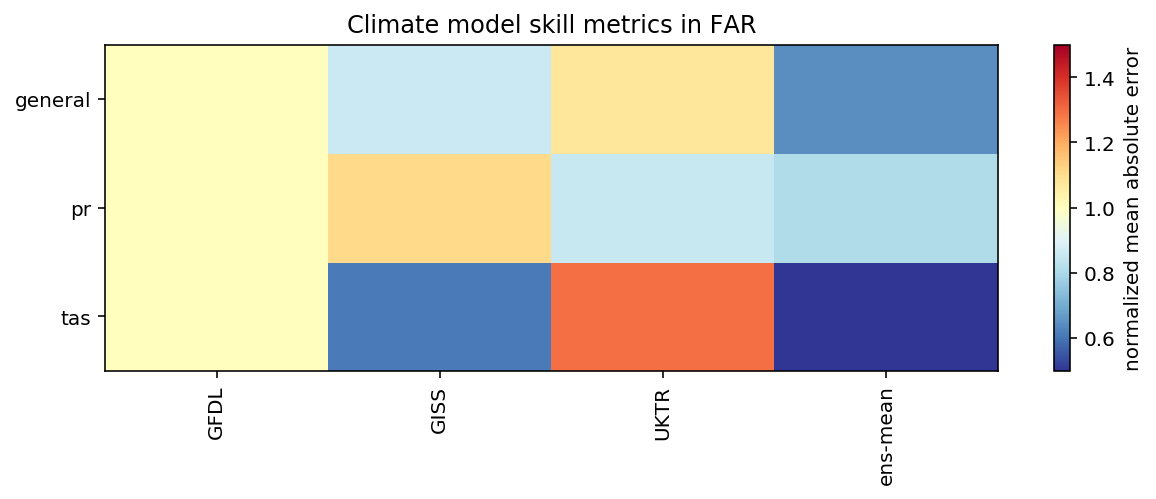

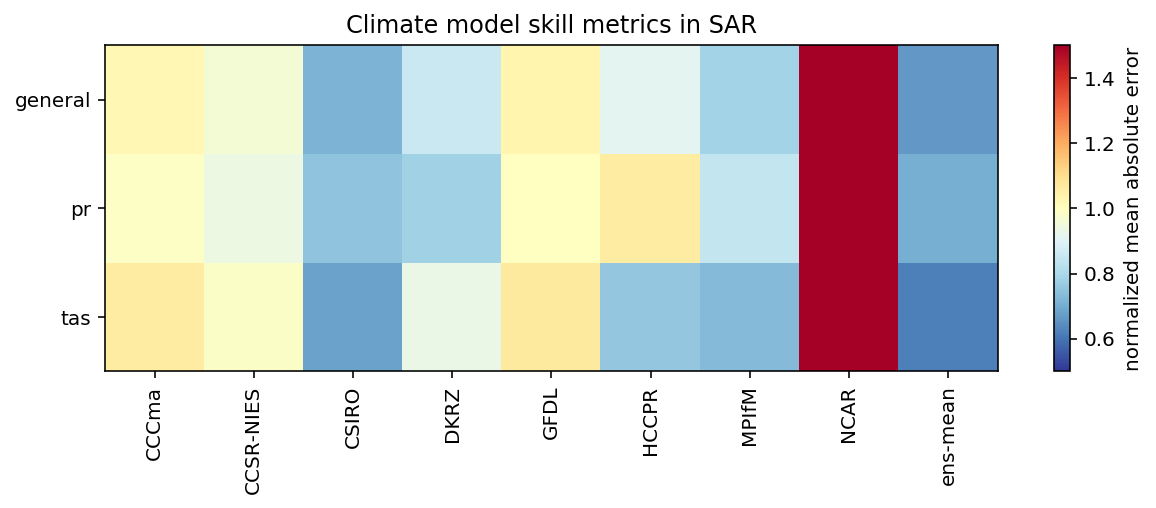

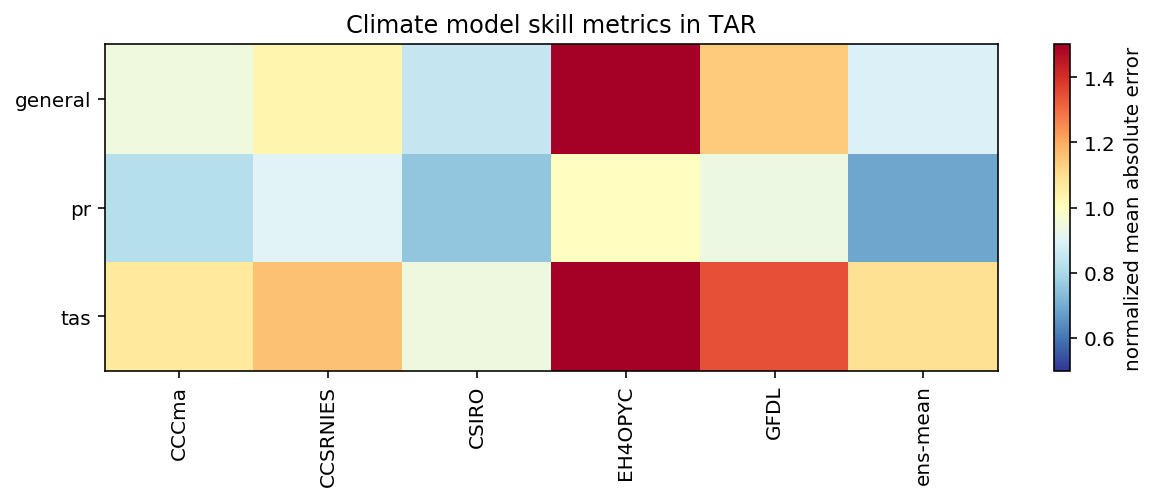

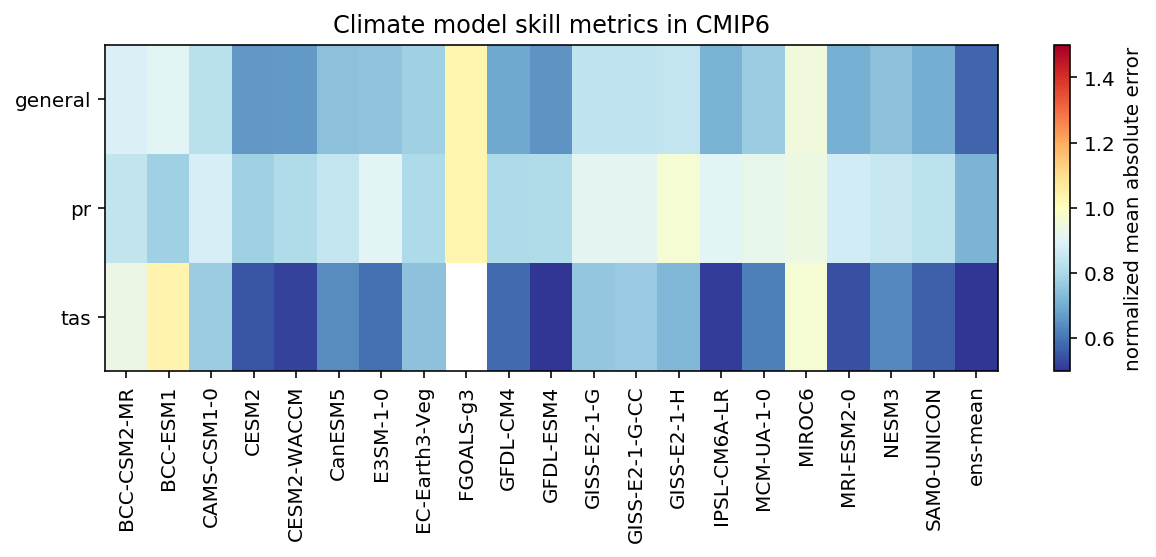

In [18]:
for key, ens in ens_dict.items():
    plt.figure(figsize=(10,3))
    q = carpet_plot(mae_skill_score_dict[key])
    plt.title("Climate model skill metrics in "+key)
    q.colorbar.set_label("normalized mean absolute error")